In [44]:
# import packages
import nfl_data_py as nfl
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from collections import defaultdict

from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import plot_tree
from sklearn.metrics import mean_squared_error as mse
from xgboost import XGBClassifier

from statsmodels.stats.contingency_tables import mcnemar

import warnings

warnings.filterwarnings('ignore')
sns.set_theme(style='whitegrid')

In [45]:
# helpful function to convert values to booleans
def boolify(x):
    return x in (1, "True", True)

In [46]:
# set flag for which metric we are calibrating LR with
# possible values are 'point diff', 'point ratio', 'pythagorean point ratio', 'dsr', 
# 'game control', 'game control signed', 'game control avg', 'game control fourth'
METRIC = 'game control avg'

In [47]:
# create dataframe containing home team, away team, point differential (home - away, 0 if OT)
games = nfl.import_schedules([2022, 2021, 2019, 2018, 2017, 2016, 2015])
games.dropna(axis=0)
games['home_team'].replace({'SD': 'LAC', 'OAK': 'LV', 'STL': 'LA'}, inplace=True)
games['away_team'].replace({'SD': 'LAC', 'OAK': 'LV', 'STL': 'LA'}, inplace=True)
games['result'] = [0 if row['overtime'] else row['result'] for (index, row) in games.iterrows()] # replace overtime scores with 0

# merge ingame_stats dataframe
ingame_stats = pd.read_csv('data/ingame_stats.csv')
games = games.merge(ingame_stats, 'inner', ['game_id', 'home_team', 'away_team'])

nfldata = games[games['season'] != 2022][[
    'away_team', 'home_team', 'away_score', 'home_score', 'total', 'result', 'overtime', 'div_game', 'game_type', 'season', 'gameday',
    'home_dsr', 'away_dsr', 'home_gc', 'away_gc', 'home_gc_signed', 'away_gc_signed', 'home_gc_avg', 'away_gc_avg', 
    'home_gc_fourthqtr', 'away_gc_fourthqtr'
    ]]
# throw out final week games?

# plt.hist(nfldata['result'], bins=len(set(nfldata['result'])))
# plt.xticks(range(-39, 40, 3), fontsize=8, rotation=90) # how were plots generated in paper?

In [48]:
# extract all home-and-home matchups
# is only using divisional matchups hurting us? divisional rivalries tend to be more of a tossup than other games
# use all games where met in reg season and playoffs and home field switched in playoffs?

hah_games = nfldata.loc[(nfldata['div_game'] == 1) & (nfldata['game_type'] == 'REG')] # get all regular season divisional games

hah_games['series'] = [
    "".join(sorted([row[1]['home_team'], row[1]['away_team'], str(row[1]['season'])]))
    for row in hah_games.iterrows()] # isolate home-and-home pairs

hah_games.sort_values(['series', 'gameday'], inplace=True) # sort values so home team in i is away team in i+1

In [49]:
# store home-and-home game data in the form [home - away in first matchup, 0 or 1 whether differential negative in second matchup]
# home team from first matchup won iff (home - away) is negative in the second matchup
# probability of outscoring team in points in next matchup or outscoring based on that metric?

match METRIC:
    case 'point diff':
        outcomes = [row['result'] for (index, row) in hah_games.reset_index().iloc[::2,:].iterrows()]
    case 'point ratio':
        outcomes = [row['home_score'] / row['total'] for (index, row) in hah_games.reset_index().iloc[::2,:].iterrows()]
    case 'pythagorean point ratio':
        outcomes = [row['home_score']**2 / (row['home_score']**2 + row['away_score']**2) 
        for (index, row) in hah_games.reset_index().iloc[::2,:].iterrows()]
    case 'dsr':
        outcomes = [row['home_dsr'] - row['away_dsr'] for (index, row) in hah_games.reset_index().iloc[::2,:].iterrows()]
    case 'game control':
        outcomes = [row['home_gc'] for (index, row) in hah_games.reset_index().iloc[::2,:].iterrows()]
    case 'game control signed':
        outcomes = [row['home_gc_signed'] for (index, row) in hah_games.reset_index().iloc[::2,:].iterrows()]
    case 'game control avg':
        outcomes = [row['home_gc_avg'] for (index, row) in hah_games.reset_index().iloc[::2,:].iterrows()]
    case 'game control fourth':
        outcomes = [row['home_gc_fourthqtr'] for (index, row) in hah_games.reset_index().iloc[::2,:].iterrows()]

logr_X = np.array(outcomes)
logr_y = np.array([int(row['result'] < 0) for (index, row) in hah_games.reset_index().iloc[1::2, :].iterrows()])

In [50]:
# train logistic regression on home-and-home matchup data (prob. of original home team winning away in next matchup)
clf = LogisticRegression().fit(logr_X.reshape(-1, 1), logr_y.reshape(-1, 1))
print(clf.coef_[0][0], clf.intercept_[0])

1.465393952169678 -0.398294853151948


In [51]:
# derive home field advantage (h = xhat / 2 = 4.9 for point diff metric)
h = min(outcomes)
for i in np.arange(min(outcomes), max(outcomes), 0.0001):
    if abs(clf.predict_proba(np.array([i]).reshape(-1, 1))[0][1] - .5) < .001:
        h = i / 2
        break
print(h)

0.13456418348974822


In [52]:
# develop Markov Chain
teams = sorted(list(set(hah_games['home_team'].tolist() + hah_games['away_team'].tolist())))
P = np.zeros((len(teams), len(teams))) # 32x32 transition matrix
n_games = np.zeros(len(teams)) # count number of games played by each team (17 except in rare cases, e.g. Bills/Bengals)
games_2022 = games[(games['season'] == 2022) & (games['game_type'] == 'REG')]

for (index, row) in games_2022.iterrows():
    home_i = teams.index(row['home_team'])
    away_i = teams.index(row['away_team'])
    match METRIC:
        case 'point diff':
            spread = row['result']
        case 'point ratio':
            spread = row['home_score'] / row['total']
        case 'pythagorean point ratio':
            spread = row['home_score']**2 / (row['home_score']**2 + row['away_score']**2)
        case 'dsr':
            spread = row['home_dsr'] - row['away_dsr']
        case 'game control':
            spread = row['home_gc']
        case 'game control signed':
            spread = row['home_gc_signed']
        case 'game control avg':
            spread = row['home_gc_avg']
        case 'game control fourth':
            spread = row['home_gc_fourthqtr']
    r_x = clf.predict_proba(np.array(spread + h).reshape(-1, 1))[0][1]

    n_games[home_i] += 1
    n_games[away_i] += 1

    P[home_i, away_i] += 1 - r_x
    P[away_i, home_i] += r_x
    P[home_i, home_i] += r_x
    P[away_i, away_i] += 1 - r_x

P /= n_games # divide each row by number of games played to normalize

In [53]:
prior = np.ones(32) / 32
steady_state = np.linalg.matrix_power(P, 1000)
ratings = prior.dot(steady_state)
rating_df = pd.DataFrame({
    'Team': teams,
    'LRMC Rating': ratings,
    'LRMC Rating Normed': ratings / max(ratings)
})

rating_df.sort_values(by=['LRMC Rating'], ascending=False, inplace=True)
rating_df.set_index('Team', inplace=True)
print(rating_df)

      LRMC Rating  LRMC Rating Normed
Team                                 
BUF      0.038218            1.000000
KC       0.038085            0.996529
PHI      0.038039            0.995319
CIN      0.036862            0.964514
BAL      0.036812            0.963212
SF       0.036156            0.946041
DAL      0.034376            0.899478
TEN      0.033074            0.865397
LAC      0.032894            0.860688
CLE      0.032018            0.837777
MIA      0.031989            0.837007
JAX      0.031819            0.832578
DET      0.031713            0.829795
PIT      0.031553            0.825615
NE       0.030960            0.810097
NO       0.030876            0.807901
LV       0.030406            0.795598
CAR      0.030166            0.789316
MIN      0.029842            0.780824
SEA      0.029697            0.777049
WAS      0.029553            0.773271
GB       0.029293            0.766461
DEN      0.029262            0.765655
NYG      0.028766            0.752680
TB       0.0

In [54]:
# linear regression for playoff prediction (in: MC loading home - away, out: exp pt diff home - away)
# fit to all regular season games in 2022
linr_X = np.array([
    rating_df.loc[row['home_team']]['LRMC Rating'] - rating_df.loc[row['away_team']]['LRMC Rating']
    for (index, row) in games_2022.iterrows()
])
linr_y = np.array([row['result'] for (index, row) in games_2022.iterrows()])
linr_clf = LinearRegression().fit(linr_X.reshape(-1, 1), linr_y.reshape(-1, 1))

# do this with logistic regression model to generate win probabilities

# intercept = home field advantage in points
print(f'x_ha = {linr_clf.coef_[0][0]} (π_h - π_a) + {linr_clf.intercept_[0]}') # diff between this home field adv and derived for pt diff?
print(f'RMSE: {mse(linr_y, linr_clf.predict(linr_X.reshape(-1, 1)), squared=False)}')
print(f"Spread RMSE: {mse(np.array([row['result'] for (index, row) in games_2022.iterrows()]), np.array([row['spread_line'] for (index, row) in games_2022.iterrows()]), squared=False)}") # RMSE for regular season

x_ha = 1150.162128539907 (π_h - π_a) + 2.127258368065727
RMSE: 10.786974938456593
Spread RMSE: 11.408144303854355


In [55]:
# compute statistics on playoff accuracy results
results = pd.read_csv('results/playoff_results.csv').transpose().rename({'Unnamed: 0' : 'year'})
results.columns = results.iloc[0]
results.drop(index='year', inplace=True)
results

year,point diff Playoff Accuracy,point diff LinReg Playoff RMSE,point diff LinReg RegSzn RMSE,point ratio Playoff Accuracy,point ratio LinReg Playoff RMSE,point ratio LinReg RegSzn RMSE,pythagorean point ratio Playoff Accuracy,pythagorean point ratio LinReg Playoff RMSE,pythagorean point ratio LinReg RegSzn RMSE,dsr Playoff Accuracy,...,game control signed LinReg RegSzn RMSE,game control avg Playoff Accuracy,game control avg LinReg Playoff RMSE,game control avg LinReg RegSzn RMSE,game control fourth Playoff Accuracy,game control fourth LinReg Playoff RMSE,game control fourth LinReg RegSzn RMSE,Spread Playoff Accuracy,Spread Playoff RMSE,Spread RegSzn RMSE
2005,0.727273,15.129903,11.561336,0.636364,15.258685,11.690904,0.545455,15.677893,11.681366,0.545455,...,11.967707,0.545455,15.523093,11.909676,0.545455,15.974836,11.936382,0.545455,14.245414,12.949798
2006,0.454545,10.834084,12.03129,0.454545,10.704991,12.211208,0.454545,10.407115,12.171961,0.545455,...,12.403039,0.636364,9.752311,12.386748,0.636364,9.575621,12.554056,0.727273,9.51912,13.5625
2007,0.454545,13.289846,11.809975,0.454545,11.168003,11.885475,0.363636,11.267192,11.832436,0.454545,...,12.197697,0.454545,13.00331,12.142899,0.454545,12.837328,12.239518,0.545455,10.960674,13.405048
2008,0.454545,13.359429,12.322356,0.454545,12.519067,12.493597,0.454545,12.302458,12.471426,0.636364,...,12.891023,0.545455,12.95435,12.839892,0.454545,12.58812,12.758026,0.636364,12.237238,13.927687
2009,0.727273,15.541676,12.999819,0.636364,16.337739,13.079965,0.727273,15.983382,13.042264,0.727273,...,13.282935,0.727273,16.837246,13.235018,0.636364,16.133283,13.240279,0.545455,16.422684,14.203666
2010,0.818182,11.634466,12.443284,0.727273,11.274644,12.520972,0.727273,11.255273,12.485439,0.727273,...,12.767406,0.818182,11.610181,12.720351,0.636364,11.955293,12.808764,0.545455,12.584261,13.947551
2011,0.636364,14.716725,12.195051,0.727273,14.4066,12.348583,0.727273,14.579895,12.320146,0.545455,...,12.546263,0.636364,15.805098,12.521361,0.727273,15.84322,12.58337,0.636364,13.366342,13.653532
2012,0.636364,11.001173,12.386009,0.636364,10.387969,12.439277,0.636364,10.5356,12.440983,0.636364,...,12.767318,0.636364,11.007155,12.730415,0.727273,11.303896,12.719528,0.727273,9.198567,14.01377
2013,0.727273,14.896556,11.002741,0.818182,13.722399,11.136142,0.818182,14.054003,11.102815,0.545455,...,11.338913,0.727273,14.429769,11.299123,0.818182,15.27195,11.240281,0.636364,14.471759,12.695079
2014,0.636364,12.428302,13.159368,0.636364,13.024612,13.246349,0.636364,13.39953,13.226306,0.636364,...,13.342531,0.545455,13.227026,13.329712,0.545455,13.842288,13.414116,0.727273,13.206403,14.466084


In [56]:
results_avg = results.apply(np.average, weights=15*[11] + 3*[13]) # weight by number of playoff games
playoff_acc = results_avg.iloc[::3].sort_values()
playoff_rmse = results_avg.iloc[1::3].sort_values()
regszn_rmse = results_avg.iloc[2::3].sort_values()
playoff_acc*204 # *204 for total correct

year
game control Playoff Accuracy               122.0
point ratio Playoff Accuracy                123.0
game control fourth Playoff Accuracy        123.0
point diff Playoff Accuracy                 124.0
pythagorean point ratio Playoff Accuracy    124.0
game control signed Playoff Accuracy        126.0
Spread Playoff Accuracy                     126.0
dsr Playoff Accuracy                        127.0
game control avg Playoff Accuracy           128.0
dtype: float64

Text(0, 0.5, 'metric')

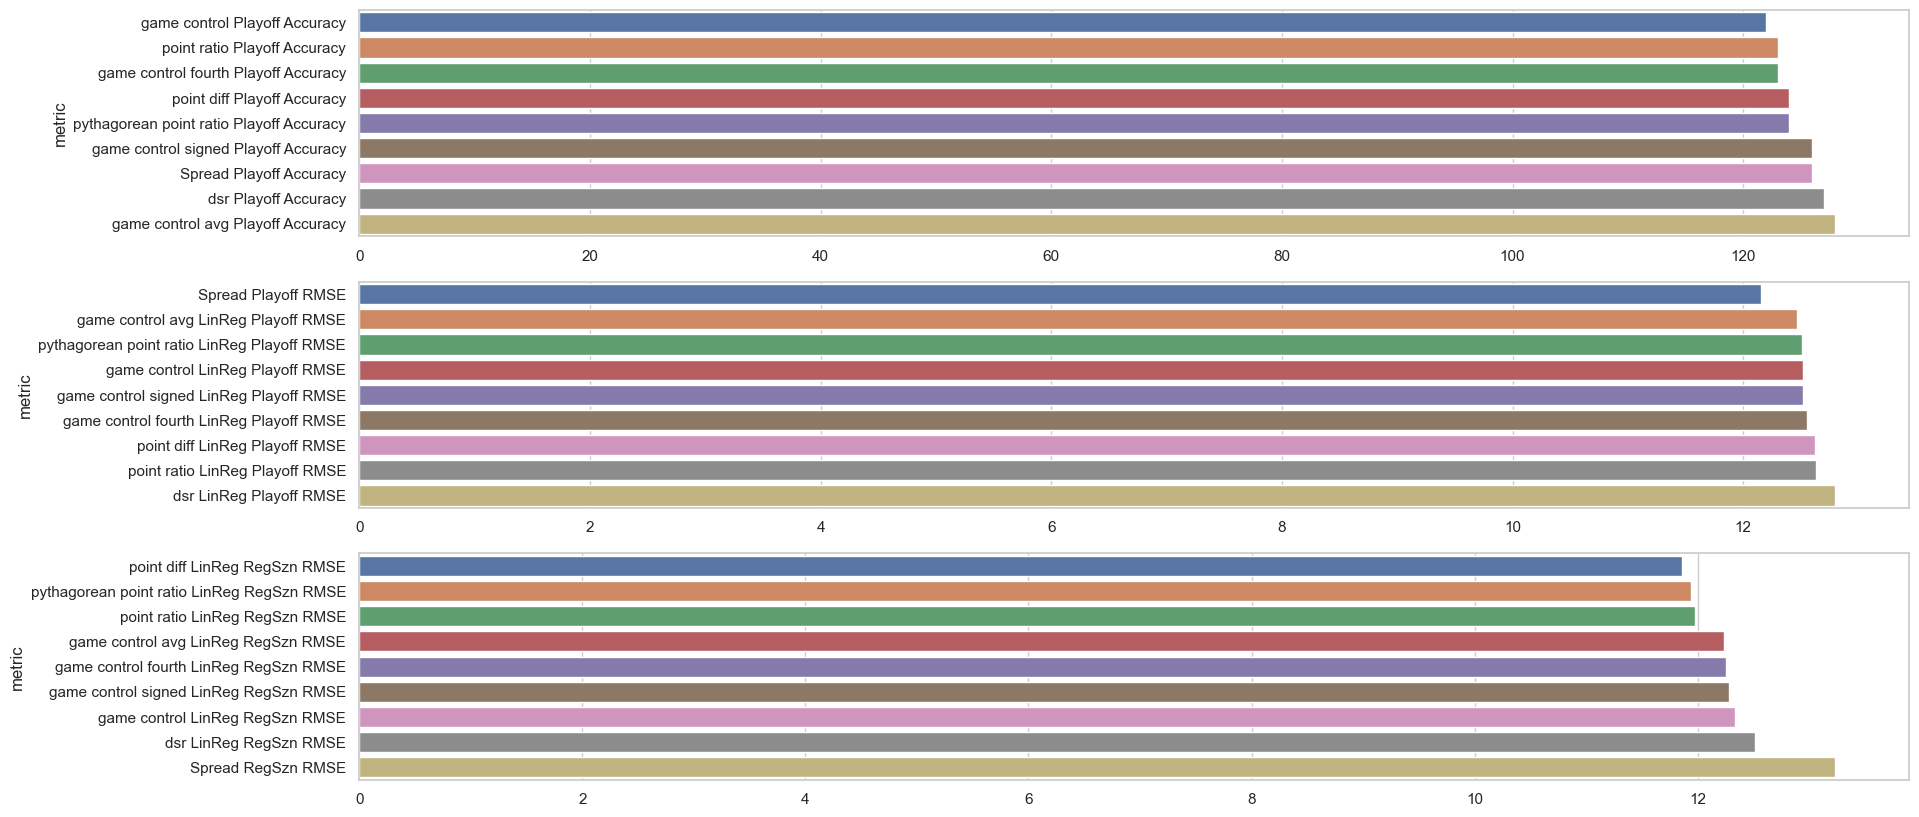

In [57]:
# plot results
fig1 = plt.figure(figsize=(20, 10))

plt.subplot(3, 1, 1)
sns.barplot(y=playoff_acc.index, x=playoff_acc*204)
plt.ylabel('metric')

plt.subplot(3, 1, 2)
sns.barplot(y=playoff_rmse.index, x=playoff_rmse)
plt.ylabel('metric')

plt.subplot(3, 1, 3)
sns.barplot(y=regszn_rmse.index, x=regszn_rmse)
plt.ylabel('metric')

In [58]:
# apply McNemar's test to determine if model differences are statistically significant
predictions = pd.read_csv('data/game_preds.csv').rename({'Unnamed: 0': 'Metric'}, axis=1)
predictions.index = predictions['Metric']
predictions.drop('Metric', axis=1, inplace=True)

for i in range(9): # convert to floats (and last row to bools)
    predictions.iloc[i] = predictions.iloc[i].apply(float)
predictions.iloc[9] = predictions.iloc[9].apply(eval)

table = np.zeros((2,2))
for i in range(8):
    for j in range(i+1, 9):
        table[0][0] = sum((predictions.iloc[i] > 0) & (predictions.iloc[j] > 0))
        table[0][1] = sum((predictions.iloc[i] > 0) & (predictions.iloc[j] < 0))
        table[1][0] = sum((predictions.iloc[i] < 0) & (predictions.iloc[j] > 0))
        table[1][1] = sum((predictions.iloc[i] < 0) & (predictions.iloc[j] < 0))
        print(f'{predictions.iloc[i].name} vs. {predictions.iloc[j].name}: {round(mcnemar(table).pvalue, 4)}')

point diff vs. point ratio: 0.6636
point diff vs. pythagorean point ratio: 0.2863
point diff vs. dsr: 0.324
point diff vs. game control: 0.5847
point diff vs. game control signed: 0.5847
point diff vs. game control avg: 0.8555
point diff vs. game control fourth: 0.4731
point diff vs. Spread Prediction: 0.0095
point ratio vs. pythagorean point ratio: 0.0117
point ratio vs. dsr: 0.6358
point ratio vs. game control: 0.3713
point ratio vs. game control signed: 0.3489
point ratio vs. game control avg: 0.5327
point ratio vs. game control fourth: 0.2559
point ratio vs. Spread Prediction: 0.0055
pythagorean point ratio vs. dsr: 0.0533
pythagorean point ratio vs. game control: 0.8642
pythagorean point ratio vs. game control signed: 0.8601
pythagorean point ratio vs. game control avg: 0.5966
pythagorean point ratio vs. game control fourth: 1.0
pythagorean point ratio vs. Spread Prediction: 0.1173
dsr vs. game control: 0.1524
dsr vs. game control signed: 0.1263
dsr vs. game control avg: 0.2221
ds

In [59]:
# in games where models differed, what is accuracy of each?
for i in range(8):
    for j in range(i+1, 9):
        diff = (predictions.iloc[i] > 0) ^ (predictions.iloc[j] > 0)
        correct = (predictions.iloc[i][diff] > 0) == predictions.loc['Playoff Result'][diff]
        print(f'{predictions.iloc[i].name} vs. {predictions.iloc[j].name}: {sum(correct)}/{sum(diff)} ({round(100*sum(correct) / sum(diff), 1)}%)')

point diff vs. point ratio: 11/21 (52.4%)
point diff vs. pythagorean point ratio: 11/22 (50.0%)
point diff vs. dsr: 17/37 (45.9%)
point diff vs. game control: 16/30 (53.3%)
point diff vs. game control signed: 14/30 (46.7%)
point diff vs. game control avg: 13/30 (43.3%)
point diff vs. game control fourth: 16/31 (51.6%)
point diff vs. Spread Prediction: 19/40 (47.5%)
point ratio vs. pythagorean point ratio: 5/11 (45.5%)
point ratio vs. dsr: 18/40 (45.0%)
point ratio vs. game control: 23/45 (51.1%)
point ratio vs. game control signed: 19/41 (46.3%)
point ratio vs. game control avg: 18/41 (43.9%)
point ratio vs. game control fourth: 19/38 (50.0%)
point ratio vs. Spread Prediction: 23/49 (46.9%)
pythagorean point ratio vs. dsr: 18/39 (46.2%)
pythagorean point ratio vs. game control: 18/34 (52.9%)
pythagorean point ratio vs. game control signed: 15/32 (46.9%)
pythagorean point ratio vs. game control avg: 14/32 (43.8%)
pythagorean point ratio vs. game control fourth: 14/27 (51.9%)
pythagorean

In [60]:
# try nonlinear combinations of the 8 LRMC models

# decision tree for playoff prediction (in: predicted spread of each linear regression, out: exp winner home/away)

linr_preds = pd.read_csv('data/linr_preds.csv').rename({'Unnamed: 0': 'game_num'}, axis=1).T # regszn
linr_preds.columns = linr_preds.iloc[0]
linr_preds.drop('game_num', inplace=True)

game_preds = pd.read_csv('data/game_preds.csv').rename({'Unnamed: 0': 'game_num'}, axis=1).T # playoffs
game_preds.columns = game_preds.iloc[0]
game_preds.drop('game_num', inplace=True)

total = 0
for i in range(2005, 2022+1):
    regszn_games = linr_preds.groupby('Year').get_group(i)
    regszn_games = regszn_games[regszn_games['Result'] != 0] # fit on all games with non-tie outcome
    train_X = regszn_games.drop(['Year', 'Result'], axis=1) # fit decision tree to regression preds for season i regszn games and outcomes
    train_Y = regszn_games['Result'] > 0

    playoff_games = game_preds.groupby('Year').get_group(str(i))
    test_X = playoff_games.drop(['Spread Prediction', 'Playoff Result', 'Year', 'Playoff Result Spread', 'Playoff Game Type'], axis=1).applymap(float)
    test_Y = playoff_games['Playoff Result'].apply(boolify) # test decision tree on playoff games for that season

    tree_clf = DecisionTreeClassifier(max_depth=8, random_state=0).fit(train_X, train_Y)
    #print(f'{i}: {tree_clf.score(test_X, test_Y)}')
    print(f'{i}: {int(tree_clf.score(test_X, test_Y)*len(test_Y))} / {len(test_Y)}')
    total += int(tree_clf.score(test_X, test_Y)*len(test_Y))

print(f'Total: {total} / 204 = {total / 204}')

2005: 5 / 11
2006: 5 / 11
2007: 5 / 11
2008: 8 / 11
2009: 7 / 11
2010: 3 / 11
2011: 8 / 11
2012: 7 / 11
2013: 6 / 11
2014: 5 / 11
2015: 8 / 11
2016: 8 / 11
2017: 8 / 11
2018: 7 / 11
2019: 4 / 11
2020: 7 / 13
2021: 7 / 13
2022: 8 / 13
Total: 116 / 204 = 0.5686274509803921


In [61]:
# fit decision tree to output of linear regressors on all playoff games from 2005-2016 and evaluate on playoffs from 2017-2022
# includes game type (WC/DIV/CON/SB) as parameter

playoff_games = game_preds.drop(['Spread Prediction', 'Playoff Result Spread'], axis=1)
playoff_games['Year'] = playoff_games['Year'].apply(float)
playoff_games['Playoff Game Type'] = playoff_games['Playoff Game Type'].apply(lambda x: 1 if x == 'WC' else 2 if x == 'DIV' else 3 if x == 'CON' else 4)
train_X = playoff_games[playoff_games['Year'].isin(range(2005, 2016+1))].drop(['Playoff Result', 'Year'], axis=1).applymap(float)
train_Y = playoff_games[playoff_games['Year'].isin(range(2005, 2016+1))]['Playoff Result']

test_X = playoff_games[playoff_games['Year'].isin(range(2017, 2022+1))].drop(['Playoff Result', 'Year'], axis=1).applymap(float)
test_Y = playoff_games[playoff_games['Year'].isin(range(2017, 2022+1))]['Playoff Result']

tree_clf = DecisionTreeClassifier(max_depth=8, random_state=0).fit(train_X, train_Y)
print(f'{int(tree_clf.score(test_X, test_Y)*len(test_X))} / {len(test_X)} = {tree_clf.score(test_X, test_Y)}')

33 / 72 = 0.4583333333333333


In [62]:
# fit as before, but with spread prediction included as a predictor

playoff_games = game_preds.drop(['Playoff Result Spread'], axis=1)
playoff_games['Year'] = playoff_games['Year'].apply(float)
playoff_games['Playoff Game Type'] = playoff_games['Playoff Game Type'].apply(lambda x: 1 if x == 'WC' else 2 if x == 'DIV' else 3 if x == 'CON' else 4)
train_X = playoff_games[playoff_games['Year'].isin(range(2005, 2016+1))].drop(['Playoff Result', 'Year'], axis=1).applymap(float)
train_Y = playoff_games[playoff_games['Year'].isin(range(2005, 2016+1))]['Playoff Result']

test_X = playoff_games[playoff_games['Year'].isin(range(2017, 2022+1))].drop(['Playoff Result', 'Year'], axis=1).applymap(float)
test_Y = playoff_games[playoff_games['Year'].isin(range(2017, 2022+1))]['Playoff Result']

tree_clf = DecisionTreeClassifier(max_depth=9, random_state=0).fit(train_X, train_Y)
print(f'{int(tree_clf.score(test_X, test_Y)*len(test_X))} / {len(test_X)} = {tree_clf.score(test_X, test_Y)}')

38 / 72 = 0.5277777777777778


In [63]:
# fit XGBoost classifier to output of linear regressors on every regular season game from 2005-2022 and evaluate on playoffs

regszn_games = linr_preds
regszn_games = regszn_games[regszn_games['Result'] != 0] # fit on all games with non-tie outcome
train_X = regszn_games.drop(['Year', 'Result'], axis=1).applymap(float) # fit decision tree to regression preds for all season regszn games and outcomes
train_Y = regszn_games['Result'] > 0

playoff_games = game_preds
test_X = playoff_games.drop(['Spread Prediction', 'Playoff Result', 'Year', 'Playoff Result Spread', 'Playoff Game Type'], axis=1).applymap(float)
test_Y = playoff_games['Playoff Result'].apply(boolify) # test decision tree on playoff games for that season

xgboost_clf = XGBClassifier(n_estimators=1000, colsample_bytree=.5, learning_rate=.05, max_depth=8, reg_alpha=.5, reg_lambda=.5, random_state=0).fit(train_X, train_Y)
print(f'Total: {xgboost_clf.score(test_X, test_Y) * 204} / 204 = {xgboost_clf.score(test_X, test_Y)}')

Total: 123.99999999999999 / 204 = 0.6078431372549019


In [64]:
# fit decision tree to output of linear regressors on every regular season game from 2005-2022 and evaluate on playoffs

regszn_games = linr_preds
regszn_games = regszn_games[regszn_games['Result'] != 0] # fit on all games with non-tie outcome
final_train_X = regszn_games.drop(['Year', 'Result'], axis=1) # fit decision tree to regression preds for all season regszn games and outcomes
final_train_Y = regszn_games['Result'] > 0

playoff_games = game_preds
final_test_X = playoff_games.drop(['Spread Prediction', 'Playoff Result', 'Year', 'Playoff Result Spread', 'Playoff Game Type'], axis=1).applymap(float)
final_test_Y = playoff_games['Playoff Result'].apply(boolify) # test decision tree on playoff games for that season

final_tree_clf = DecisionTreeClassifier(max_depth=8, random_state=0).fit(final_train_X, final_train_Y)
print(f'Total: {final_tree_clf.score(final_test_X, final_test_Y) * 204} / 204 = {final_tree_clf.score(final_test_X, final_test_Y)}')

# plot tree (left is True for direction, left is False for leaf result)
# plt.figure(figsize=(64, 20))
# plot_tree(tree_clf, fontsize=5, feature_names=train_X.columns, precision=1, filled=True)
# plt.savefig('results/decision_tree.png', dpi=100)

Total: 125.00000000000001 / 204 = 0.6127450980392157


game_num,point diff,point ratio,pythagorean point ratio,dsr,game control,game control signed,game control avg,game control fourth,Spread Prediction,Playoff Result Spread
count,204.000000,204.000000,204.000000,204.000000,204.000000,204.000000,204.000000,204.000000,204.000000,204.000000
mean,4.151560,3.828145,3.972187,3.377761,4.243892,4.145796,3.997650,4.053282,4.257353,3.563725
std,6.499237,5.695201,5.550560,5.541231,6.044347,6.102439,6.005134,5.648045,4.690541,13.086332
min,-11.314276,-9.349578,-10.540461,-11.073814,-14.452640,-13.429735,-13.329304,-10.289226,-10.000000,-35.000000
25%,-0.019723,-0.207831,0.528700,-0.830270,0.219667,0.496747,0.242495,0.535531,2.500000,-4.000000
50%,4.175204,4.402444,4.297554,3.519399,4.532038,4.298010,4.105193,4.189784,4.000000,3.000000
75%,8.821746,7.635157,7.791870,7.277176,8.217451,8.268915,8.171572,7.925003,7.500000,13.000000
max,23.654733,17.901985,18.709624,18.905743,19.932655,19.616102,19.084243,21.764355,16.000000,38.000000


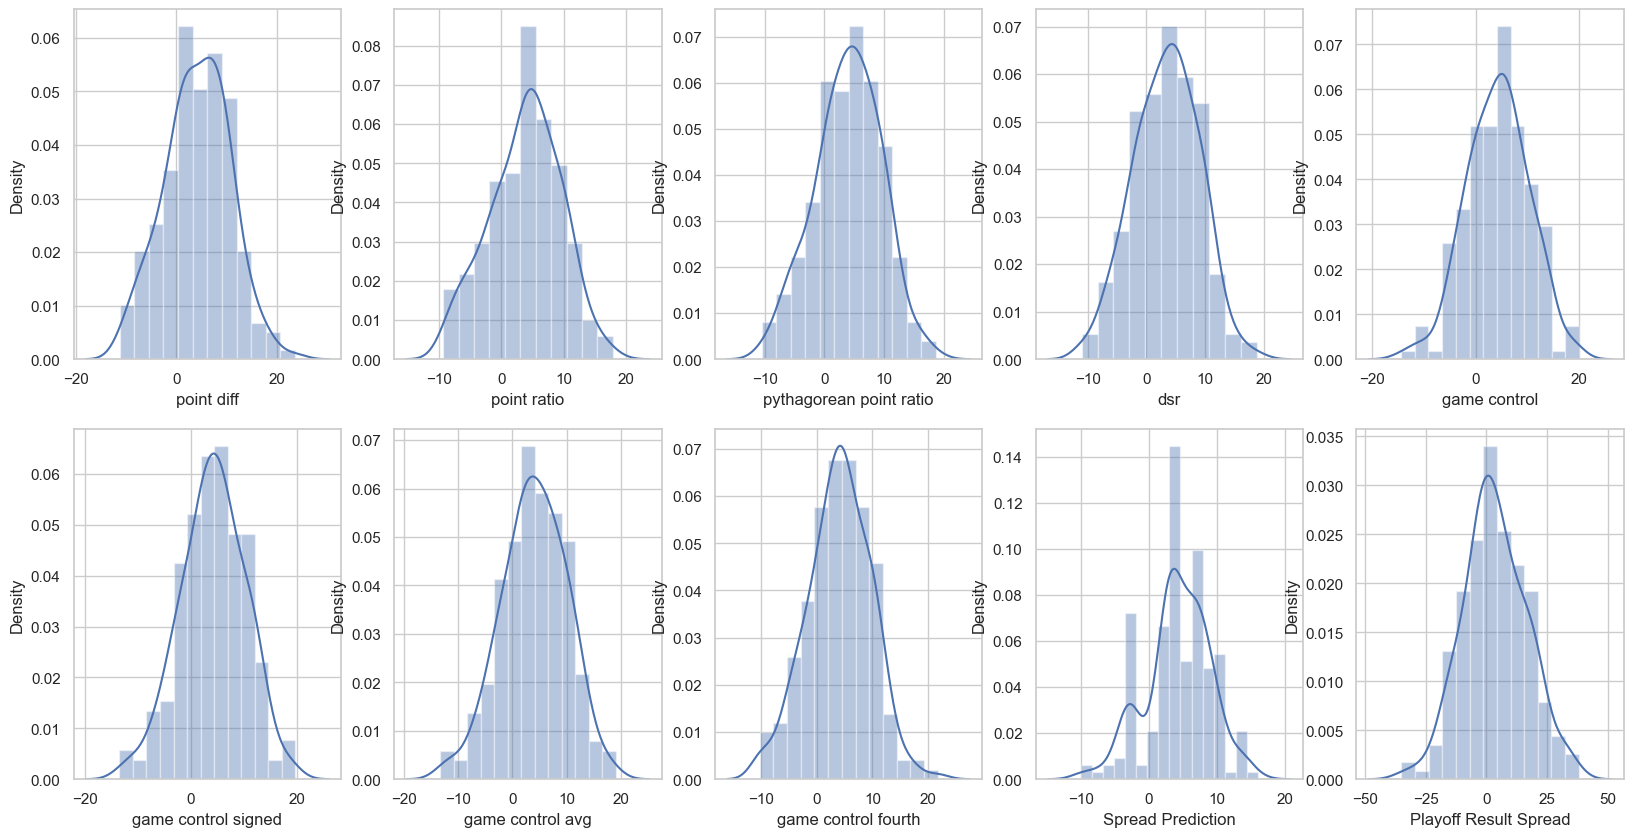

In [65]:
# distribution of each regressor's playoff predictions (do some tend to predict larger numbers? dist of difference vs actual?)

predictors = game_preds.drop(['Year', 'Playoff Result', 'Playoff Game Type'], axis=1).applymap(float)
plt.figure(figsize=(20,10))

for i in range(len(predictors.columns)):
    plt.subplot(2, 5, i+1)
    sns.distplot(predictors.iloc[:, i])

predictors.describe()

In [66]:
# McNemar's test for decision tree model vs spread and each individual model
# predictions = pd.read_csv('data/game_preds.csv').rename({'Unnamed: 0': 'Metric'}, axis=1)
# predictions.index = predictions['Metric']
# predictions.drop('Metric', axis=1, inplace=True)
predictions.loc['tree'] = final_tree_clf.predict(final_test_X)
correct_vals = predictions.loc['Playoff Result']

table = np.zeros((2,2))
for i in range(9):
    table[0][0] = sum(((predictions.iloc[i] > 0) == correct_vals) & (predictions.loc['tree'].apply(boolify) == correct_vals))
    table[0][1] = sum(((predictions.iloc[i] > 0) == correct_vals) & (predictions.loc['tree'].apply(boolify) != correct_vals))
    table[1][0] = sum(((predictions.iloc[i] > 0) != correct_vals) & (predictions.loc['tree'].apply(boolify) == correct_vals))
    table[1][1] = sum(((predictions.iloc[i] > 0) != correct_vals) & (predictions.loc['tree'].apply(boolify) != correct_vals))
    print(f'{predictions.iloc[i].name}: \n {table}')
    print(f'{predictions.iloc[i].name} vs. tree: {round(mcnemar(table).pvalue, 4)} {"(Significant)" if mcnemar(table).pvalue < .05 else ""}\n')

point diff: 
 [[105.  19.]
 [ 20.  60.]]
point diff vs. tree: 1.0 

point ratio: 
 [[102.  21.]
 [ 23.  58.]]
point ratio vs. tree: 0.8804 

pythagorean point ratio: 
 [[104.  20.]
 [ 21.  59.]]
pythagorean point ratio vs. tree: 1.0 

dsr: 
 [[100.  27.]
 [ 25.  52.]]
dsr vs. tree: 0.8899 

game control: 
 [[104.  18.]
 [ 21.  61.]]
game control vs. tree: 0.7493 

game control signed: 
 [[108.  18.]
 [ 17.  61.]]
game control signed vs. tree: 1.0 

game control avg: 
 [[109.  19.]
 [ 16.  60.]]
game control avg vs. tree: 0.7359 

game control fourth: 
 [[108.  15.]
 [ 17.  64.]]
game control fourth vs. tree: 0.8601 

Spread Prediction: 
 [[103.  23.]
 [ 22.  56.]]
Spread Prediction vs. tree: 1.0 



In [67]:
# in games where they differed, what is the accuracy of each
for i in range(9):
    diff = (predictions.iloc[i] > 0) ^ predictions.loc['tree'].apply(boolify)
    correct = (predictions.loc['tree'][diff] > 0) == predictions.loc['Playoff Result'][diff]
    print(f'tree vs. {predictions.iloc[i].name}: {sum(correct)}/{sum(diff)} ({round(100*sum(correct) / sum(diff), 1)}%)')

tree vs. point diff: 20/39 (51.3%)
tree vs. point ratio: 23/44 (52.3%)
tree vs. pythagorean point ratio: 21/41 (51.2%)
tree vs. dsr: 25/52 (48.1%)
tree vs. game control: 21/39 (53.8%)
tree vs. game control signed: 17/35 (48.6%)
tree vs. game control avg: 16/35 (45.7%)
tree vs. game control fourth: 17/32 (53.1%)
tree vs. Spread Prediction: 22/45 (48.9%)


In [68]:
# prep dataset for raw metric accuracy
tgames = nfl.import_schedules(list(range(2005, 2023)))
tgames.dropna(axis=0)
tgames['home_team'].replace({'SD': 'LAC', 'OAK': 'LV', 'STL': 'LA'}, inplace=True)
tgames['away_team'].replace({'SD': 'LAC', 'OAK': 'LV', 'STL': 'LA'}, inplace=True)
tgames['result'] = [0 if row['overtime'] else row['result'] for (index, row) in tgames.iterrows()] # replace overtime scores with 0

# merge ingame_stats dataframe
ingame_stats = pd.read_csv('data/ingame_stats.csv')
tgames = tgames.merge(ingame_stats, 'inner', ['game_id', 'home_team', 'away_team'])

In [69]:
# accuracy of basic metrics
raw_acc = defaultdict(list)

# win/loss, pythagorean points

for year in range(2005, 2023):
    szngames = tgames[tgames['season'] == year]
    teams = defaultdict(lambda: [0, 0, 0])
    teams_pts = defaultdict(lambda: [0, 0])
    for (i, game) in szngames[szngames['game_type'] == 'REG'].iterrows():
        teams[game['home_team']][0] += game['result'] > 0
        teams[game['home_team']][1] += game['result'] < 0
        teams[game['away_team']][0] += game['result'] < 0
        teams[game['away_team']][1] += game['result'] > 0
        teams[game['home_team']][2] += game['result'] == 0
        teams[game['away_team']][2] += game['result'] == 0

        teams_pts[game['home_team']][0] += game['home_score']
        teams_pts[game['home_team']][1] += game['away_score']
        teams_pts[game['away_team']][0] += game['away_score']
        teams_pts[game['away_team']][1] += game['home_score']

    winp = {k:((v[0] + 0.5*v[2]) / sum(v)) for k,v in teams.items()}
    pyth = {k: (v[0]**2 / (v[0]**2 + v[1]**2)) for k,v in teams_pts.items()}

    correct, correct_pts, total = 0, 0, 0
    for (i, game) in szngames[szngames.game_type != 'REG'].iterrows():
        correct += (game['result'] > 0) == (winp[game['home_team']] >= winp[game['away_team']])
        correct_pts += (game['result'] > 0) == (pyth[game['home_team']] >= pyth[game['away_team']])
        total += 1
    raw_acc['year'].append(year)
    raw_acc['wlt'].append(correct)
    raw_acc['pyth'].append(correct_pts)
    raw_acc['games'].append(total)

raw_acc = pd.DataFrame(raw_acc)
print(f"wlt: {sum(raw_acc['wlt'])} / {sum(raw_acc['games'])} = {sum(raw_acc.wlt) / sum(raw_acc.games)}")
print(f"pythagorean wins: {sum(raw_acc['pyth'])} / {sum(raw_acc['games'])} = {sum(raw_acc.pyth) / sum(raw_acc.games)}")

wlt: 115 / 204 = 0.5637254901960784
pythagorean wins: 128 / 204 = 0.6274509803921569


In [70]:
# accuracy of raw metrics
raw_acc_sums = defaultdict(list)
# for each season, for each metric, calculate each team's cumulative/avg metric over the season, predict playoffs
metrics = ['point diff', 'point ratio', 'dsr', 'game control', 'gc signed', 'gc avg', 'gc fourth']
for year in range(2005, 2023):
    teams = defaultdict(lambda: defaultdict(lambda: 0))
    for (i, game) in tgames[(tgames['game_type'] == 'REG') & (tgames['season'] == year)].iterrows():
        teams[game['home_team']]['point diff'] += game['result']
        teams[game['away_team']]['point diff'] += -game['result']
        teams[game['home_team']]['point ratio'] += game['home_score'] / game['total']
        teams[game['away_team']]['point ratio'] += game['away_score'] / game['total']
        teams[game['home_team']]['dsr'] += game['home_dsr']
        teams[game['away_team']]['dsr'] += game['away_dsr']
        teams[game['home_team']]['game control'] += game['home_gc']
        teams[game['away_team']]['game control'] += game['away_gc']
        teams[game['home_team']]['gc signed'] += game['home_gc_signed']
        teams[game['away_team']]['gc signed'] += game['away_gc_signed']
        teams[game['home_team']]['gc avg'] += game['home_gc_avg']
        teams[game['away_team']]['gc avg'] += game['away_gc_avg']
        teams[game['home_team']]['gc fourth'] += game['home_gc_fourthqtr']
        teams[game['away_team']]['gc fourth'] += game['away_gc_fourthqtr']

    for metric in metrics:
        correct, total = 0, 0
        for (i, game) in tgames[(tgames['game_type'] != 'REG') & (tgames['season'] == year)].iterrows():
            correct += (game['result'] > 0) == (teams[game['home_team']][metric] >= teams[game['away_team']][metric])
            total += 1
        raw_acc_sums[metric].append(correct)
        #print(f'{year} {metric}: {correct}/{total}')
    raw_acc_sums['year'].append(year)
    raw_acc_sums['games'].append(total)

raw_acc_sums = pd.DataFrame(raw_acc_sums)
raw_metric_acc = raw_acc_sums.drop('games', axis=1).merge(raw_acc, 'outer', 'year')
raw_metric_acc

,point diff,point ratio,dsr,game control,gc signed,gc avg,gc fourth,year,wlt,pyth,games
0,8,7,6,5,5,6,6,2005,5,7,11
1,5,5,7,6,5,5,6,2006,6,6,11
2,5,5,7,5,5,5,5,2007,7,5,11
3,6,7,5,6,6,6,6,2008,5,4,11
4,6,8,7,8,7,7,8,2009,5,8,11
5,9,8,7,7,7,7,6,2010,5,9,11
6,6,7,6,5,6,6,7,2011,7,7,11
7,7,7,4,5,6,6,6,2012,6,7,11
8,8,8,6,6,7,7,7,2013,7,8,11
9,9,8,8,8,8,9,5,2014,8,7,11


In [71]:
for col in raw_metric_acc.columns:
    if col not in ('year', 'games'):
        print(f'{col}: {sum(raw_metric_acc[col])} / {sum(raw_metric_acc.games)} = {sum(raw_metric_acc[col]) / sum(raw_metric_acc.games)}')

point diff: 128 / 204 = 0.6274509803921569
point ratio: 125 / 204 = 0.6127450980392157
dsr: 118 / 204 = 0.5784313725490197
game control: 120 / 204 = 0.5882352941176471
gc signed: 118 / 204 = 0.5784313725490197
gc avg: 120 / 204 = 0.5882352941176471
gc fourth: 123 / 204 = 0.6029411764705882
wlt: 115 / 204 = 0.5637254901960784
pyth: 128 / 204 = 0.6274509803921569


In [112]:
# assess performance by playoff game type

type_acc = pd.read_csv('data/game_preds.csv').rename({'Unnamed: 0': 'game_num'}, axis=1).T
type_acc.columns = type_acc.iloc[0]
type_acc.drop('game_num', inplace=True)

wc_games = type_acc[type_acc['Playoff Game Type'] == 'WC'].drop(['Year', 'Playoff Result Spread', 'Playoff Game Type'], axis=1)
for col in wc_games.columns:
    wc_games[col] = (wc_games[col].apply(eval) > 0) == wc_games['Playoff Result'].apply(eval)
print('WILD CARD')
print(wc_games.apply(sum), end='\n\n')

div_games = type_acc[type_acc['Playoff Game Type'] == 'DIV'].drop(['Year', 'Playoff Result Spread', 'Playoff Game Type'], axis=1)
for col in div_games.columns:
    div_games[col] = (div_games[col].apply(eval) > 0) == div_games['Playoff Result'].apply(eval)
print("DIVISIONAL")
print(div_games.apply(sum), end='\n\n')

ch_games = type_acc[(type_acc['Playoff Game Type'] == 'CON') | (type_acc['Playoff Game Type'] == 'SB')].drop(['Year', 'Playoff Result Spread', 'Playoff Game Type'], axis=1)
for col in ch_games.columns:
    ch_games[col] = (ch_games[col].apply(eval) > 0) == ch_games['Playoff Result'].apply(eval)
print('CONF/SB')
print(ch_games.apply(sum))

WILD CARD
game_num
point diff                 53
point ratio                54
pythagorean point ratio    52
dsr                        54
game control               48
game control signed        49
game control avg           50
game control fourth        52
Spread Prediction          51
Playoff Result             78
dtype: int64

DIVISIONAL
game_num
point diff                 43
point ratio                41
pythagorean point ratio    42
dsr                        46
game control               44
game control signed        47
game control avg           48
game control fourth        44
Spread Prediction          43
Playoff Result             72
dtype: int64

CONF/SB
game_num
point diff                 28
point ratio                28
pythagorean point ratio    30
dsr                        27
game control               30
game control signed        30
game control avg           30
game control fourth        27
Spread Prediction          32
Playoff Result             54
dtype: int64


In [131]:
# accuracy of raw metrics by playoff game type
raw_acc_type = defaultdict(list)
# for each season, for each metric, calculate each team's cumulative/avg metric over the season, predict playoffs
metrics = ['point diff', 'point ratio', 'dsr', 'game control', 'gc signed', 'gc avg', 'gc fourth']
for year in range(2005, 2023):
    teams = defaultdict(lambda: defaultdict(lambda: 0))
    for (i, game) in tgames[(tgames['game_type'] == 'REG') & (tgames['season'] == year)].iterrows():
        teams[game['home_team']]['point diff'] += game['result']
        teams[game['away_team']]['point diff'] += -game['result']
        teams[game['home_team']]['point ratio'] += game['home_score'] / game['total']
        teams[game['away_team']]['point ratio'] += game['away_score'] / game['total']
        teams[game['home_team']]['dsr'] += game['home_dsr']
        teams[game['away_team']]['dsr'] += game['away_dsr']
        teams[game['home_team']]['game control'] += game['home_gc']
        teams[game['away_team']]['game control'] += game['away_gc']
        teams[game['home_team']]['gc signed'] += game['home_gc_signed']
        teams[game['away_team']]['gc signed'] += game['away_gc_signed']
        teams[game['home_team']]['gc avg'] += game['home_gc_avg']
        teams[game['away_team']]['gc avg'] += game['away_gc_avg']
        teams[game['home_team']]['gc fourth'] += game['home_gc_fourthqtr']
        teams[game['away_team']]['gc fourth'] += game['away_gc_fourthqtr']

    for metric in metrics:
        for (i, game) in tgames[(tgames['game_type'] != 'REG') & (tgames['season'] == year)].iterrows():
            correct = (game['result'] > 0) == (teams[game['home_team']][metric] >= teams[game['away_team']][metric])
            raw_acc_type[metric].append(correct)

    for (i, game) in tgames[(tgames['game_type'] != 'REG') & (tgames['season'] == year)].iterrows():
        raw_acc_type['game_type'].append(game['game_type'])

raw_acc_type = pd.DataFrame(raw_acc_type)
raw_acc_type

wc_raw_games = raw_acc_type[raw_acc_type['game_type'] == 'WC'].drop('game_type', axis=1)
wc_raw_games.apply(sum) # out of 78

div_raw_games = raw_acc_type[raw_acc_type['game_type'] == 'DIV'].drop('game_type', axis=1)
div_raw_games.apply(sum) # out of 72

ch_raw_games = raw_acc_type[(raw_acc_type['game_type'] == 'CON') | (raw_acc_type['game_type'] == 'SB')].drop('game_type', axis=1)
ch_raw_games.apply(sum) # out of 54

point diff      28
point ratio     27
dsr             31
game control    30
gc signed       28
gc avg          28
gc fourth       28
dtype: int64